# BÁO CÁO BÀI TẬP THỰC HÀNH VÀ ĐỒ ÁN CUỐI KỲ

In [1]:
# import các thư viện
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import display
from tqdm import tqdm

In [2]:
# Các biến toàn cục

# thư mục gốc chứa thư mục dữ liệu
szWorkingDir = "/kaggle/input/car-cs114"

# dùng để hiển thị
nNumImgsPerRow = 10
nImgHeight = nImgWidth = 150

In [3]:
# mapping
labels = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8
}
reverse_map_labels = {
    0: 'Others',
    1: 'Honda',
    2: 'Hyundai',
    3: 'KIA',
    4: 'Mazda',
    5: 'Mitsubishi',
    6: 'Suzuki',
    7: 'Toyota',
    8: 'VinFast'
}

Đoạn mã bao gồm:

* File csv chứa ảnh lỗi: Không thể đọc được
* File csv chứa thông tin kênh màu, độ trong suốt
* File csv chứa thông tin các ảnh trùng được phát hiện thông qua bài tập Clustering (trong phần này là tập Train-1)
* Và đường dẫn dataset và train-1.csv

In [4]:
path_img = os.path.join(szWorkingDir, "dataset")

error = pd.read_csv(os.path.join(szWorkingDir,"ImageErrors.csv"))

error_paths = error.iloc[:, 0].unique().tolist() # Lấy thông tin đường dẫn ảnh lỗi

In [5]:
csv_dir = os.path.join(szWorkingDir,"car_split/car_split")
#Link train
img_path_train =os.path.join(csv_dir,"CarDataset-Splits-1-Train.csv")

#Đọc File train
data = pd.read_csv(img_path_train)

In [6]:
data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2        Others/22520459-22520507-22520862.Others.23.jpg           0
3       Others/22521027-22520195-22521060.Others.307.jpg           0
4                Others/22520394-22520395.Others.578.jpg           0
...                                                  ...         ...
29382          VinFast/22521070-22520211.VinFast.167.jpg           8
29383           VinFast/21522373-21522499.VinFast.10.png           8
29384            VinFast/22521692-22521676.VinFast.7.jpg           8
29385  VinFast/22521259-22521213-22521463.VinFast.13.jpg           8
29386  VinFast/22521027-22520195-22521060.VinFast.092...           8

[29387 rows x 2 columns]

In [7]:
# Loại bỏ các ảnh có trong error_paths
data = data[~data['ImageFullPath'].isin(error_paths)]
data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2        Others/22520459-22520507-22520862.Others.23.jpg           0
3       Others/22521027-22520195-22521060.Others.307.jpg           0
4                Others/22520394-22520395.Others.578.jpg           0
...                                                  ...         ...
29382          VinFast/22521070-22520211.VinFast.167.jpg           8
29383           VinFast/21522373-21522499.VinFast.10.png           8
29384            VinFast/22521692-22521676.VinFast.7.jpg           8
29385  VinFast/22521259-22521213-22521463.VinFast.13.jpg           8
29386  VinFast/22521027-22520195-22521060.VinFast.092...           8

[29369 rows x 2 columns]

In [8]:
# Đọc file chứa thông tin ảnh trùng
duplicates_df = pd.read_csv('/kaggle/input/car-cs114/CheckDuplicate/CheckDuplicate_Train_1.csv')
duplicates_df

ImageFullPath  ClusterID
0               Others/22521492-22521599.Others.137.jpg          0
1               Others/22521492-22521599.Others.130.jpg          0
2               Others/22521070-22520211.Others.167.jpg          1
3               Others/22520779-22521587.Others.948.jpg          1
4                Others/22521492-22521599.Others.83.jpg          2
...                                                 ...        ...
1450  VinFast/22520348-22520530-22520837.VinFast.41....        139
1451           VinFast/22521692-22521676.VinFast.15.jpg        140
1452           VinFast/21522373-21522499.VinFast.10.png        140
1453           VinFast/22520477-22520490.VinFast.20.jpg        141
1454  VinFast/22521027-22520195-22521060.VinFast.025...        141

[1455 rows x 2 columns]

In [9]:
# Lấy các nhóm ảnh trùng
duplicate_groups = duplicates_df.groupby('ClusterID')['ImageFullPath'].agg(list)

# Xử lý từng nhóm trùng
for group in duplicate_groups:
    if len(group) > 1:
        # Chọn ngẫu nhiên 1 ảnh giữ lại
        keep_image = np.random.choice(group, 1)[0]
        # Lấy các ảnh cần loại bỏ
        remove_images = [img for img in group if img != keep_image]
        # Loại bỏ ảnh trùng trong DataFrame
        data = data[~data['ImageFullPath'].isin(remove_images)]

data

ImageFullPath  CategoryID
0                Others/22520394-22520395.Others.547.jpg           0
1                Others/22520394-22520395.Others.181.jpg           0
2        Others/22520459-22520507-22520862.Others.23.jpg           0
3       Others/22521027-22520195-22521060.Others.307.jpg           0
4                Others/22520394-22520395.Others.578.jpg           0
...                                                  ...         ...
29381           VinFast/22521560-22521614.VinFast.23.jpg           8
29382          VinFast/22521070-22520211.VinFast.167.jpg           8
29383           VinFast/21522373-21522499.VinFast.10.png           8
29385  VinFast/22521259-22521213-22521463.VinFast.13.jpg           8
29386  VinFast/22521027-22520195-22521060.VinFast.092...           8

[28058 rows x 2 columns]

Train and val data

In [12]:
img = data['ImageFullPath']
label = data['CategoryID']
image = [os.path.join(path_img, i) for i in img]
len(image)

28058

Chia tập train và val (Train 80%, Val 20%)

In [13]:
train_X, val_X, train_Y, val_Y = train_test_split(image, label, test_size=0.2, random_state=30)
train_label_count = Counter(train_Y)
val_label_count = Counter(val_Y)
print(train_label_count)
print(val_label_count)

Counter({6: 4231, 7: 3684, 0: 2682, 2: 2147, 3: 2111, 4: 2061, 1: 2016, 5: 1840, 8: 1674})
Counter({6: 1021, 7: 895, 0: 687, 1: 550, 2: 531, 3: 521, 4: 515, 5: 462, 8: 430})


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


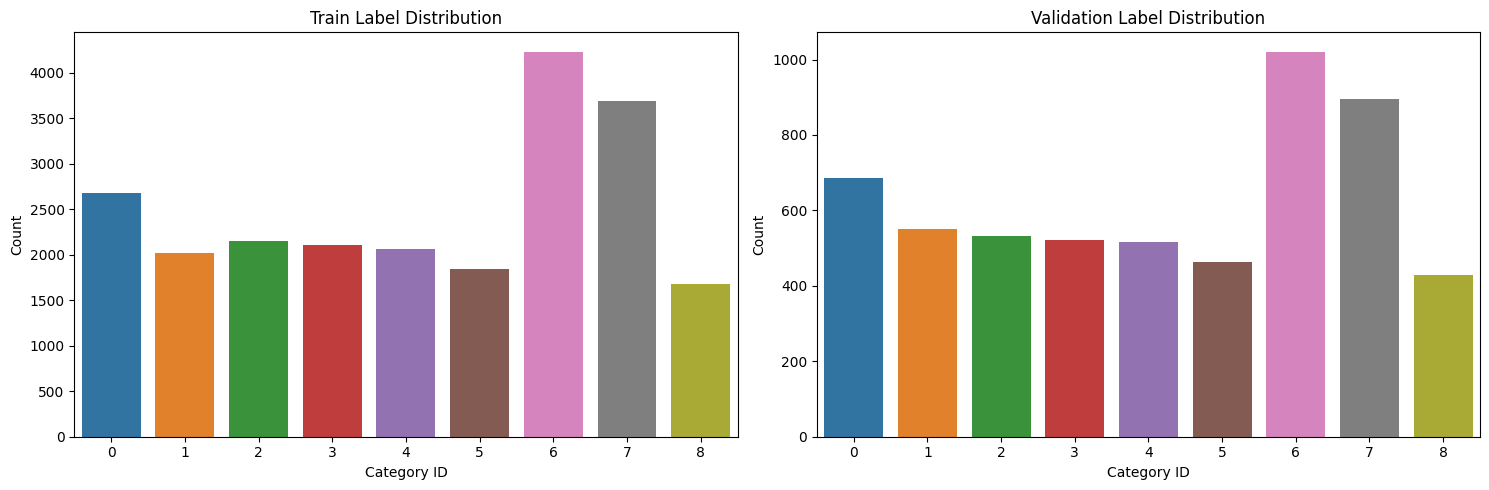

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Giả sử 'train_Y' và 'val_Y' là nhãn của dữ liệu huấn luyện và kiểm tra
train_label_count = Counter(train_Y)
val_label_count = Counter(val_Y)

# Vẽ biểu đồ phân phối nhãn cho cả train và val
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train label distribution
sns.barplot(x=list(train_label_count.keys()), y=list(train_label_count.values()), ax=axes[0])
axes[0].set_title('Train Label Distribution')
axes[0].set_xlabel('Category ID')
axes[0].set_ylabel('Count')

# Validation label distribution
sns.barplot(x=list(val_label_count.keys()), y=list(val_label_count.values()), ax=axes[1])
axes[1].set_title('Validation Label Distribution')
axes[1].set_xlabel('Category ID')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Dùng để hiển thị

* nNumImgsPerRow = 10
* nImgHeight = nImgWidth = 150

In [15]:
# Số lượng các danh mục hoặc lớp ảnh khác nhau
classes = 9

# Kích thước của mỗi ảnh trong hình
figsize_per_image = (2, 2)

def display_images(data):

    images = {}

    # Lặp qua từng lớp
    for Class in range(classes):
        # Lọc dataframe theo lớp hiện tại
        class_df = data[data['CategoryID'] == Class]

        # Lấy ngẫu nhiên các đường dẫn ảnh từ dataframe đã lọc
        sample_images = class_df.sample(n=min(nNumImgsPerRow, len(class_df)))['ImageFullPath']

        # Tải và thay đổi kích thước từng ảnh được chọn, lưu vào dictionary `images`
        images[Class] = [cv2.resize(cv2.imread(os.path.join(path_img, img_path), cv2.IMREAD_COLOR), (nImgWidth, nImgHeight)) for img_path in sample_images]

    # Tính toán kích thước hình dựa trên số lượng ảnh và số lớp
    figsize = (figsize_per_image[0] * (nNumImgsPerRow + 1), figsize_per_image[1] * classes)

    # Tạo các ô con (subplot) với số dòng là số lớp và số cột là `NumImgsPerRow + 1`
    fig, axes = plt.subplots(classes, nNumImgsPerRow + 1, figsize=figsize)

    # Hiển thị ảnh
    for i in tqdm(range(classes)):
        for j in range(nNumImgsPerRow + 1):
            # Lấy ô subplot hiện tại
            ax = axes[i, j]

            # Nếu là cột đầu tiên, hiển thị nhãn lớp
            if j == 0:
                ax.text(0.5, 0.5, f'{reverse_map_labels[i]}', va='center', ha='center', transform=ax.transAxes, fontsize=14, fontweight='bold')
            # Nếu không, hiển thị ảnh nếu tồn tại
            elif j-1 < len(images[i]):
                ax.imshow(cv2.cvtColor(images[i][j-1], cv2.COLOR_BGR2RGB))

            # Ẩn các đường viền trục để giao diện gọn gàng hơn
            ax.axis('off')

    # Điều chỉnh bố cục để tránh chồng lấn và hiển thị hình
    plt.tight_layout()
    plt.show()

100%|██████████| 9/9 [00:00<00:00, 95.82it/s]


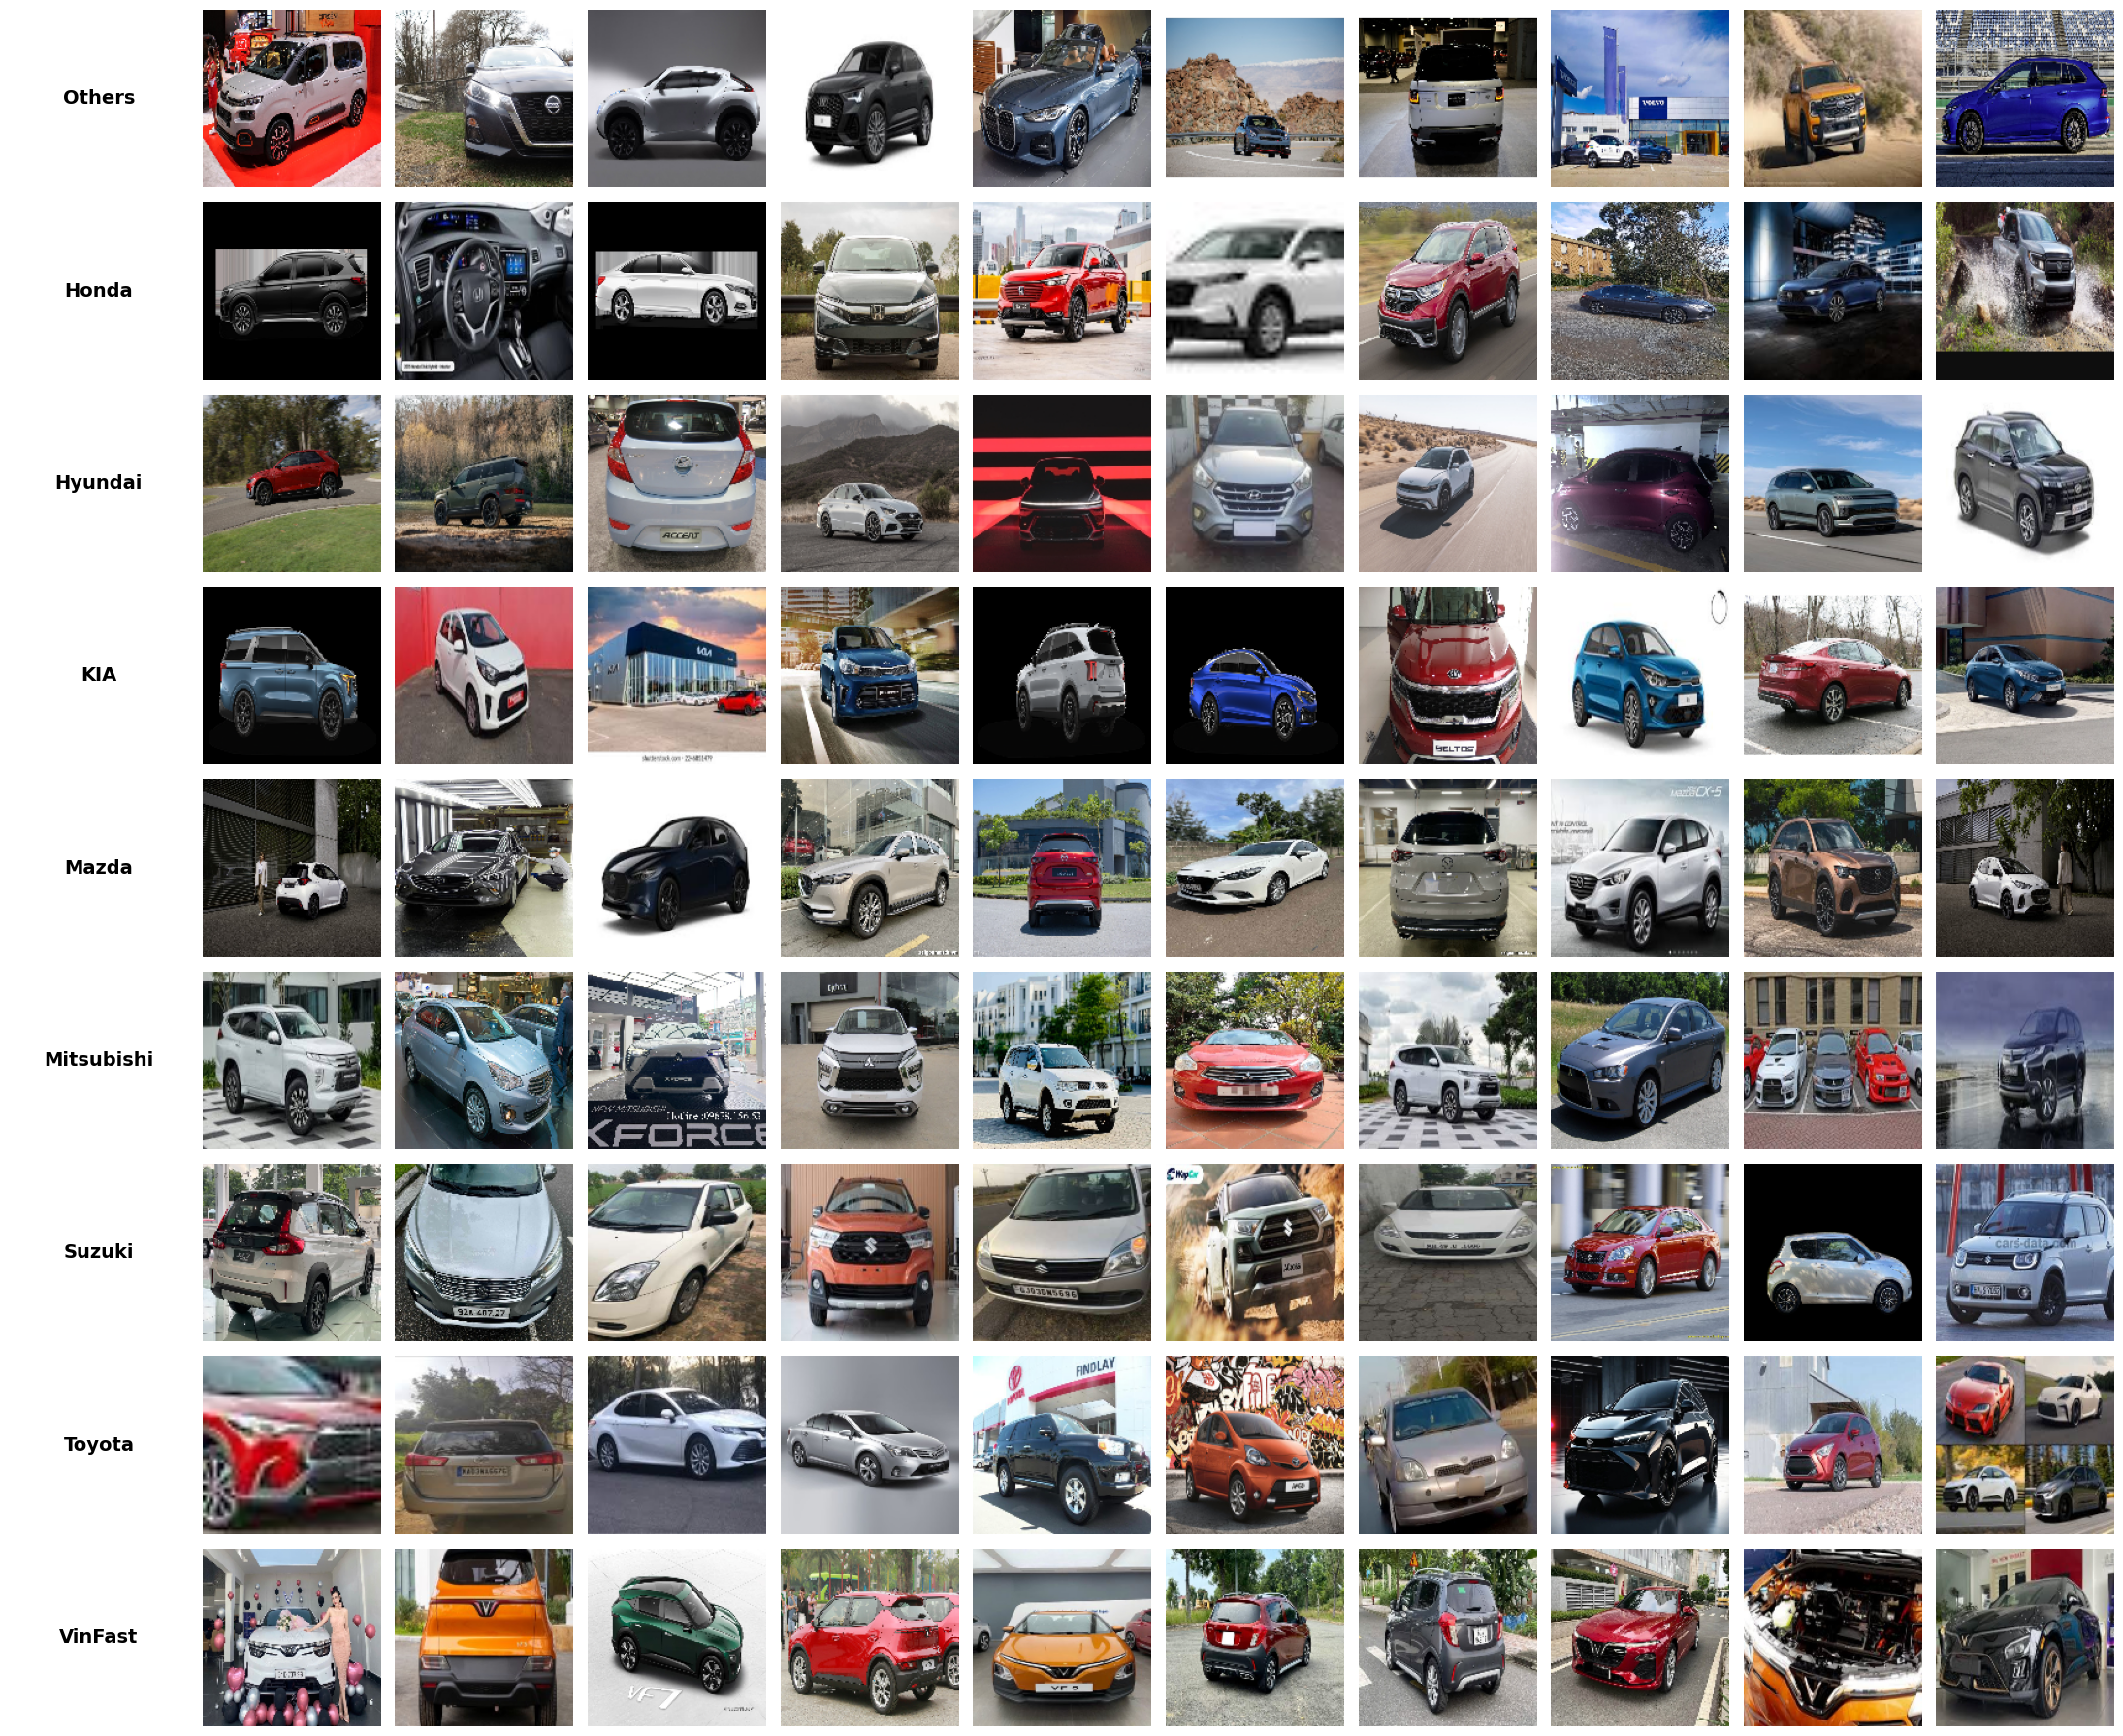

In [16]:
display_images(data)

In [17]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Thêm bước chuyển đổi sang RGB
        transforms.Resize(224, interpolation=Image.BILINEAR),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(224),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.RandomHorizontalFlip(),  # Lật ngang ảnh ngẫu nhiên để tăng cường dữ liệu
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # Thêm bước chuyển đổi sang RGB
        transforms.Resize(224, interpolation=Image.BILINEAR),  # Thay đổi kích thước ảnh thành 224x224
        transforms.CenterCrop(224),  # Cắt ảnh từ giữa để có kích thước 224x224
        transforms.ToTensor(),  # Chuyển ảnh từ định dạng PIL sang tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Chuẩn hóa ảnh dựa trên thông số của ImageNet
    ]),
}

In [18]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        # Mở ảnh bằng Pillow
        img_pil = Image.open(img_path)
        # Chuyển đổi sang RGB nếu không phải
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')

        # Áp dụng các phép biến đổi
        if self.transform:
            img_pil = self.transform(img_pil)

        return img_pil, label

In [20]:
train_set = CustomDataset(train_X, train_Y, transform=data_transforms['train'])
val_set = CustomDataset(val_X,val_Y, transform=data_transforms['val'])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True,num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, pin_memory=True,num_workers= 4)

In [ ]:
train_set[0]

(tensor([[[1.3413, 1.8379, 1.8037,  ..., 2.2318, 2.1804, 2.2318],
          [1.1872, 1.9064, 1.7352,  ..., 2.2318, 2.1804, 2.2318],
          [0.9817, 1.9235, 1.6838,  ..., 2.2318, 2.1975, 2.2318],
          ...,
          [2.0948, 2.0777, 2.1290,  ..., 2.0605, 2.0263, 2.0777],
          [2.0605, 2.0434, 2.1290,  ..., 2.1290, 2.0777, 2.1462],
          [1.9920, 1.9749, 2.0777,  ..., 2.1804, 2.1290, 2.1633]],
 
         [[1.6232, 2.1310, 2.0959,  ..., 2.1835, 2.0784, 2.1660],
          [1.4657, 2.2010, 2.0259,  ..., 2.1660, 2.0784, 2.1660],
          [1.2556, 2.2185, 1.9734,  ..., 2.1485, 2.0959, 2.1485],
          ...,
          [2.1134, 2.0959, 2.1485,  ..., 2.1485, 2.1134, 2.1660],
          [2.0784, 2.0609, 2.1485,  ..., 2.2185, 2.1660, 2.2360],
          [2.0084, 1.9909, 2.0959,  ..., 2.2885, 2.2185, 2.2535]],
 
         [[1.9777, 2.4831, 2.4483,  ..., 1.7685, 1.6814, 1.7860],
          [1.8208, 2.5354, 2.3786,  ..., 1.7511, 1.6814, 1.7860],
          [1.6117, 2.5354, 2.3263,  ...,

In [ ]:
val_set[0]

(tensor([[[ 1.0844,  1.0673,  1.0673,  ...,  0.7077,  0.7077,  0.7077],
          [ 1.0844,  1.0673,  1.0673,  ...,  0.7248,  0.7248,  0.7077],
          [ 1.0331,  1.0331,  1.0331,  ...,  0.7591,  0.7419,  0.7248],
          ...,
          [-1.1760, -1.2274, -1.2274,  ..., -0.8507, -0.9020, -0.9534],
          [-1.0390, -1.1075, -1.1075,  ..., -1.0562, -0.9192, -0.9192],
          [-1.1589, -1.1247, -1.2445,  ..., -0.9705, -0.8507, -0.8849]],
 
         [[ 1.0630,  1.0455,  1.0455,  ...,  0.6604,  0.6604,  0.6604],
          [ 1.0630,  1.0630,  1.0630,  ...,  0.6604,  0.6604,  0.6604],
          [ 1.0630,  1.0805,  1.0805,  ...,  0.6604,  0.6429,  0.6604],
          ...,
          [-1.1429, -1.1954, -1.1954,  ..., -0.9153, -0.9503, -1.0028],
          [-1.0028, -1.0728, -1.0728,  ..., -1.1253, -0.9678, -0.9503],
          [-1.1253, -1.0903, -1.2129,  ..., -1.0203, -0.9153, -0.9328]],
 
         [[ 1.2631,  1.2457,  1.2457,  ...,  0.8448,  0.8274,  0.8274],
          [ 1.2805,  1.2631,

Show 16 ảnh trong 1 batch

In [23]:
def show_batch_images(images, labels, mean, std, max_images=16):
    # Ensure mean and std are numpy arrays
    mean = np.array(mean)
    std = np.array(std)

    plt.figure(figsize=(12, 12))
    for i in range(min(len(images), max_images)):
        image = images[i].numpy().transpose((1, 2, 0))  # Transpose tensor from (C, H, W) to (H, W, C)

        # Denormalize
        image = std * image + mean
        image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

        plt.subplot(4, 4, i + 1)  # 4 rows and 4 columns
        plt.imshow(image)
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()

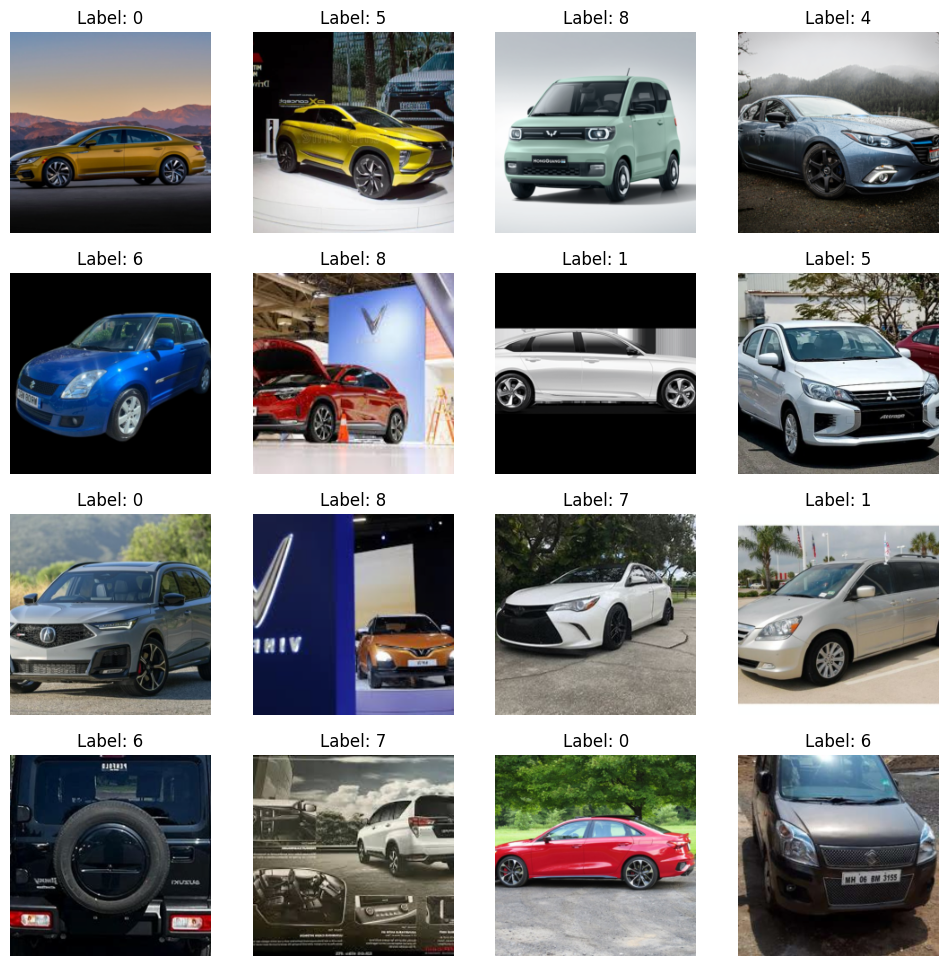

In [24]:
batch_images, batch_labels = next(iter(train_loader))  # Replace data_loader with your actual DataLoader
show_batch_images(batch_images, batch_labels, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [25]:
from tempfile import TemporaryDirectory
import torch.optim as optim
import time
import torchvision.models as models
from torch.optim import lr_scheduler

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
import torch
# Kiểm tra GPU memory trước khi load model
print(f"GPU memory before model: {torch.cuda.memory_allocated()/1e9:.2f} GB")
torch.cuda.empty_cache()

GPU memory before model: 0.00 GB


In [29]:
model_ft = models.regnet_y_128gf(weights='RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_LINEAR_V1')

# Unfreeze the last few layers
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze the last block and the final fully connected layer
for param in model_ft.trunk_output.block4.parameters():
    param.requires_grad = True

# Replace the last fully connected layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 9)  # Assuming you have 5 classes
)

# Move model to device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_lc_swag-cbe8ce12.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_lc_swag-cbe8ce12.pth
100%|██████████| 2.40G/2.40G [00:29<00:00, 87.9MB/s]


In [ ]:
model_ft

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [30]:
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define learning rate scheduler (decay LR by a factor of 0.1 every 7 epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15, train_loader=None, val_loader=None, device=None):
    since = time.time()
    best_acc = 0.0
    best_model_params_path = '/kaggle/working/regnet_tune.pt'
    
    # Histories
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    # Grad scaler for mixed precision
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f'{phase} {epoch+1}/{num_epochs}'):
                try:
                    # Move input and labels to device
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    # Verify shapes and values
                    assert inputs.shape[1:] == (3, 224, 224), f"Wrong input shape: {inputs.shape}"
                    assert labels.shape[0] == inputs.shape[0], f"Batch size mismatch: {labels.shape} vs {inputs.shape}"
                    assert torch.all(labels >= 0) and torch.all(labels < 9), f"Labels out of range: {labels.min()}-{labels.max()}"
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # Forward
                    with torch.set_grad_enabled(phase == 'train'):
                        with torch.amp.autocast('cuda'):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            _, preds = torch.max(outputs, 1)
                        
                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                except Exception as e:
                    print(f"Error in batch processing: {str(e)}")
                    print(f"Input shape: {inputs.shape}")
                    print(f"Labels shape: {labels.shape}")
                    print(f"Unique labels: {torch.unique(labels)}")
                    raise e
            
            # Epoch statistics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                
            # Update histories
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [34]:
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, train_loader=train_loader, val_loader=val_loader, device=device
)

Epoch 1/30
------------------------------


train 1/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/30:   8%|▊         | 54/702 [00:53<10:40,  1.01it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/30:   9%|▉         | 64/702 [01:03<10:43,  1.01s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 1/30: 100%|██████████| 702/702 [12:47<00:00,  1.09s/it]


train Loss: 1.0070 Acc: 0.6690


val 1/30:   1%|          | 1/176 [00:02<07:25,  2.54s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/30:   2%|▏         | 4/176 [00:05<03:20,  1.16s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/30:   9%|▉         | 16/176 [00:16<02:32,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/30:  71%|███████   | 125/176 [02:01<00:49,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 1/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.6629 Acc: 0.7883

Epoch 2/30
------------------------------


train 2/30:   0%|          | 2/702 [00:03<16:36,  1.42s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/30:   6%|▌         | 43/702 [00:48<12:15,  1.12s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/30:  11%|█▏        | 80/702 [01:29<11:17,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/30:  24%|██▎       | 165/702 [03:03<09:48,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 2/30: 100%|██████████| 702/702 [12:56<00:00,  1.11

train Loss: 0.5743 Acc: 0.8236


val 2/30:  11%|█         | 19/176 [00:20<02:30,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/30:  26%|██▌       | 45/176 [00:45<02:07,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/30:  70%|███████   | 124/176 [02:01<00:49,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 2/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.6024 Acc: 0.8131

Epoch 3/30
------------------------------


train 3/30:   3%|▎         | 23/702 [00:26<13:06,  1.16s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/30:   5%|▌         | 37/702 [00:42<12:30,  1.13s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/30:  10%|▉         | 68/702 [01:16<11:26,  1.08s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/30:  23%|██▎       | 158/702 [02:55<10:01,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 3/30: 100%|██████████| 702/702 [12:50<00:00,  1.1

train Loss: 0.3866 Acc: 0.8815


val 3/30:  32%|███▏      | 57/176 [00:56<01:54,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/30:  56%|█████▋    | 99/176 [01:36<01:13,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/30:  57%|█████▋    | 100/176 [01:37<01:12,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/30:  65%|██████▍   | 114/176 [01:50<00:58,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 3/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.5713 Acc: 0.8293

Epoch 4/30
------------------------------


train 4/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/30:   3%|▎         | 19/702 [00:21<12:55,  1.14s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/30:  10%|▉         | 68/702 [01:16<11:26,  1.08s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 4/30: 100%|██████████| 702/702 [12:55<00:00,  1.10s/it]


train Loss: 0.2866 Acc: 0.9153


val 4/30:  47%|████▋     | 83/176 [01:20<01:29,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/30:  52%|█████▏    | 92/176 [01:29<01:21,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/30:  62%|██████▎   | 110/176 [01:46<01:03,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/30:  73%|███████▎  | 129/176 [02:05<00:45,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 4/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.5092 Acc: 0.8514

Epoch 5/30
------------------------------


train 5/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/30:   1%|▏         | 9/702 [00:11<12:50,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/30:  13%|█▎        | 91/702 [01:42<11:08,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 5/30: 100%|██████████| 702/702 [12:54<00:00,  1.10s/it]


train Loss: 0.2041 Acc: 0.9376


val 5/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/30:   1%|          | 1/176 [00:02<06:13,  2.14s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/30:  10%|▉         | 17/176 [00:17<02:32,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/30:  44%|████▍     | 78/176 [01:16<01:34,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 5/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.5824 Acc: 0.8475

Epoch 6/30
------------------------------


train 6/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/30:   3%|▎         | 21/702 [00:24<12:30,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/30:  16%|█▌        | 110/702 [02:02<10:46,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/30:  22%|██▏       | 151/702 [02:47<10:02,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 6/30: 100%|██████████| 702/702 [12:53<00:00,  1.10s/it]


train Loss: 0.0915 Acc: 0.9738


val 6/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/30:   5%|▍         | 8/176 [00:08<02:43,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/30:  53%|█████▎    | 94/176 [01:31<01:19,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/30:  79%|███████▉  | 139/176 [02:14<00:35,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 6/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.4865 Acc: 0.8708

Epoch 7/30
------------------------------


train 7/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/30:   0%|          | 1/702 [00:02<26:06,  2.23s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/30:   4%|▍         | 27/702 [00:31<13:10,  1.17s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/30:   9%|▉         | 65/702 [01:13<11:27,  1.08s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 7/30: 100%|██████████| 702/702 [12:52<00:00,  1.10s/it]


train Loss: 0.0515 Acc: 0.9856


val 7/30:  11%|█         | 19/176 [00:19<02:30,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/30:  16%|█▌        | 28/176 [00:28<02:23,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/30:  51%|█████     | 89/176 [01:27<01:23,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/30:  69%|██████▉   | 122/176 [01:58<00:51,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 7/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.5166 Acc: 0.8765

Epoch 8/30
------------------------------


train 8/30:   1%|▏         | 10/702 [00:12<12:44,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/30:  12%|█▏        | 84/702 [01:34<11:12,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/30:  18%|█▊        | 129/702 [02:24<10:31,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/30:  19%|█▊        | 131/702 [02:26<10:30,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 8/30: 100%|██████████| 702/702 [12:52<00:00,  1.

train Loss: 0.0350 Acc: 0.9892


val 8/30:   3%|▎         | 5/176 [00:05<02:58,  1.04s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/30:  15%|█▍        | 26/176 [00:25<02:24,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/30:  44%|████▍     | 77/176 [01:15<01:35,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/30:  68%|██████▊   | 119/176 [01:55<00:55,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 8/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.5482 Acc: 0.8744

Epoch 9/30
------------------------------


train 9/30:   2%|▏         | 16/702 [00:18<12:36,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/30:   3%|▎         | 18/702 [00:21<12:35,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/30:   5%|▍         | 35/702 [00:39<12:20,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/30:  17%|█▋        | 117/702 [02:10<10:50,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 9/30: 100%|██████████| 702/702 [12:56<00:00,  1.1

train Loss: 0.0265 Acc: 0.9924


val 9/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 9/30:  38%|███▊      | 66/176 [01:04<01:46,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 9/30: 100%|██████████| 176/176 [02:50<00:00,  1.04it/s]


val Loss: 0.5691 Acc: 0.8804

Epoch 10/30
------------------------------


train 10/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/30:   6%|▌         | 43/702 [00:49<12:13,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/30:   8%|▊         | 56/702 [01:03<11:45,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/30:  17%|█▋        | 117/702 [02:10<10:50,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 10/30: 100%|██████████| 702/702 [12:53<00:00,  1.10s/i

train Loss: 0.0240 Acc: 0.9931


val 10/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/30:   9%|▊         | 15/176 [00:15<02:34,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/30:  28%|██▊       | 50/176 [00:49<02:01,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/30:  55%|█████▌    | 97/176 [01:34<01:16,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 10/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.6008 Acc: 0.8774

Epoch 11/30
------------------------------


train 11/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/30:   1%|          | 4/702 [00:05<15:14,  1.31s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/30:   6%|▌         | 43/702 [00:49<12:11,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 11/30: 100%|██████████| 702/702 [12:52<00:00,  1.10s/it]


train Loss: 0.0151 Acc: 0.9956


val 11/30:   1%|          | 2/176 [00:02<03:42,  1.28s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/30:  32%|███▏      | 57/176 [00:55<01:55,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/30:  61%|██████    | 107/176 [01:44<01:06,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 11/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.6194 Acc: 0.8756

Epoch 12/30
------------------------------


train 12/30:   3%|▎         | 21/702 [00:24<12:29,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/30:   4%|▍         | 28/702 [00:31<12:23,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/30:   4%|▍         | 31/702 [00:35<12:23,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/30:  11%|█         | 78/702 [01:27<11:30,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 12/30: 100%|██████████| 702/702 [12:54<00:00, 

train Loss: 0.0144 Acc: 0.9958


val 12/30:  22%|██▏       | 39/176 [00:38<02:12,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/30:  35%|███▌      | 62/176 [01:01<01:50,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/30:  82%|████████▏ | 144/176 [02:19<00:30,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/30:  85%|████████▍ | 149/176 [02:24<00:25,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 12/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/

val Loss: 0.6041 Acc: 0.8799

Epoch 13/30
------------------------------


train 13/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/30:   1%|          | 4/702 [00:05<14:16,  1.23s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/30:   1%|          | 6/702 [00:07<13:18,  1.15s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/30:   8%|▊         | 53/702 [00:59<12:01,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 13/30: 100%|██████████| 702/702 [12:53<00:00,  1.10s/it]


train Loss: 0.0153 Acc: 0.9956


val 13/30:  12%|█▏        | 21/176 [00:21<02:29,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/30:  18%|█▊        | 31/176 [00:30<02:20,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/30:  51%|█████     | 90/176 [01:28<01:22,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 13/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.5967 Acc: 0.8790

Epoch 14/30
------------------------------


train 14/30:   2%|▏         | 12/702 [00:15<12:45,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/30:   7%|▋         | 50/702 [00:57<12:00,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/30:  10%|█         | 73/702 [01:23<11:33,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/30:  18%|█▊        | 127/702 [02:22<10:39,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 14/30: 100%|██████████| 702/702 [12:54<00:00,

train Loss: 0.0154 Acc: 0.9959


val 14/30:  16%|█▋        | 29/176 [00:29<02:20,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/30:  28%|██▊       | 50/176 [00:49<02:00,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/30:  57%|█████▋    | 100/176 [01:37<01:12,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 14/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.6342 Acc: 0.8801

Epoch 15/30
------------------------------


train 15/30:   1%|          | 4/702 [00:05<14:01,  1.21s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/30:   4%|▎         | 25/702 [00:28<12:26,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/30:  11%|█▏        | 79/702 [01:28<11:33,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/30:  17%|█▋        | 118/702 [02:11<10:44,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 15/30: 100%|██████████| 702/702 [12:54<00:00, 

train Loss: 0.0112 Acc: 0.9965


val 15/30:  18%|█▊        | 32/176 [00:32<02:19,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 15/30:  20%|█▉        | 35/176 [00:35<02:17,  1.02it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 15/30:  55%|█████▌    | 97/176 [01:34<01:15,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 15/30:  92%|█████████▏| 162/176 [02:37<00:13,  1.02it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 15/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s

val Loss: 0.6218 Acc: 0.8788

Epoch 16/30
------------------------------


train 16/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 16/30:   5%|▌         | 38/702 [00:42<12:12,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 16/30:   6%|▋         | 45/702 [00:50<12:04,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 16/30:  20%|█▉        | 139/702 [02:34<10:16,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 16/30: 100%|██████████| 702/702 [12:55<00:00,  1.10s/i

train Loss: 0.0123 Acc: 0.9961


val 16/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 16/30:  36%|███▌      | 63/176 [01:01<01:48,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 16/30:  53%|█████▎    | 93/176 [01:30<01:19,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 16/30:  73%|███████▎  | 128/176 [02:04<00:46,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 16/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.6088 Acc: 0.8803

Epoch 17/30
------------------------------


train 17/30:   0%|          | 2/702 [00:03<17:54,  1.54s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 17/30:   2%|▏         | 13/702 [00:15<12:50,  1.12s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 17/30:   2%|▏         | 16/702 [00:18<12:45,  1.12s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 17/30:   8%|▊         | 55/702 [01:01<11:51,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 17/30: 100%|██████████| 702/702 [12:56<00:00,  

train Loss: 0.0130 Acc: 0.9964


val 17/30:   2%|▏         | 3/176 [00:05<04:07,  1.43s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 17/30:  32%|███▏      | 56/176 [00:55<01:55,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 17/30:  38%|███▊      | 66/176 [01:05<01:45,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 17/30:  51%|█████     | 90/176 [01:28<01:23,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 17/30: 100%|██████████| 176/176 [02:51<00:00,  1.03it/s]


val Loss: 0.6158 Acc: 0.8795

Epoch 18/30
------------------------------


train 18/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 18/30:   1%|          | 6/702 [00:07<13:32,  1.17s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 18/30:   4%|▍         | 27/702 [00:31<12:32,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 18/30:   6%|▋         | 45/702 [00:51<12:11,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 18/30: 100%|██████████| 702/702 [12:55<00:00,  1.11s/it]

train Loss: 0.0107 Acc: 0.9970


val 18/30:   9%|▊         | 15/176 [00:15<02:34,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 18/30:   9%|▉         | 16/176 [00:16<02:33,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 18/30:  15%|█▍        | 26/176 [00:26<02:24,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 18/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.6203 Acc: 0.8776

Epoch 19/30
------------------------------


train 19/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 19/30:   1%|          | 6/702 [00:07<13:09,  1.13s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 19/30:   3%|▎         | 23/702 [00:25<12:29,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 19/30: 100%|██████████| 702/702 [12:53<00:00,  1.10s/it]


train Loss: 0.0131 Acc: 0.9962


val 19/30:  21%|██        | 37/176 [00:37<02:15,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 19/30:  28%|██▊       | 50/176 [00:50<02:02,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 19/30:  29%|██▉       | 51/176 [00:51<02:01,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 19/30:  93%|█████████▎| 164/176 [02:39<00:11,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 19/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s

val Loss: 0.6211 Acc: 0.8788

Epoch 20/30
------------------------------


train 20/30:   5%|▍         | 35/702 [00:39<12:21,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 20/30:   6%|▋         | 44/702 [00:49<12:12,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 20/30:   6%|▋         | 45/702 [00:50<12:10,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 20/30:   7%|▋         | 46/702 [00:52<12:09,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 20/30: 100%|██████████| 702/702 [12:48<00:00, 

train Loss: 0.0118 Acc: 0.9968


val 20/30:   2%|▏         | 4/176 [00:05<03:16,  1.14s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 20/30:  21%|██        | 37/176 [00:37<02:14,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 20/30:  42%|████▏     | 74/176 [01:12<01:38,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 20/30:  47%|████▋     | 83/176 [01:21<01:29,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 20/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.6238 Acc: 0.8792

Epoch 21/30
------------------------------


train 21/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 21/30:   1%|▏         | 9/702 [00:11<12:56,  1.12s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 21/30:   2%|▏         | 15/702 [00:17<12:40,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 21/30:  10%|▉         | 70/702 [01:18<11:28,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 21/30: 100%|██████████| 702/702 [12:54<00:00,  1.10s/it]

train Loss: 0.0133 Acc: 0.9959


val 21/30:   5%|▌         | 9/176 [00:10<02:42,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 21/30:  10%|█         | 18/176 [00:18<02:30,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 21/30:  36%|███▋      | 64/176 [01:03<01:48,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 21/30:  77%|███████▋  | 135/176 [02:11<00:38,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 21/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]

val Loss: 0.6241 Acc: 0.8799

Epoch 22/30
------------------------------


train 22/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 22/30:   1%|          | 8/702 [00:09<12:53,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 22/30:   7%|▋         | 50/702 [00:56<12:05,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 22/30:   8%|▊         | 53/702 [00:59<12:02,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 22/30: 100%|██████████| 702/702 [12:52<00:00,  1.10s/it]

train Loss: 0.0111 Acc: 0.9969


val 22/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 22/30:   5%|▌         | 9/176 [00:09<02:41,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 22/30:  40%|████      | 71/176 [01:09<01:40,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 22/30:  88%|████████▊ | 154/176 [02:28<00:20,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 22/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.6147 Acc: 0.8799

Epoch 23/30
------------------------------


train 23/30:   6%|▌         | 41/702 [00:46<12:15,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 23/30:   8%|▊         | 59/702 [01:05<11:41,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 23/30:  13%|█▎        | 92/702 [01:42<11:14,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 23/30:  26%|██▋       | 186/702 [03:26<09:34,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 23/30: 100%|██████████| 702/702 [12:54<00:00,

train Loss: 0.0128 Acc: 0.9967


val 23/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 23/30:   6%|▋         | 11/176 [00:11<02:39,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 23/30:  11%|█▏        | 20/176 [00:20<02:28,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 23/30:  28%|██▊       | 50/176 [00:48<02:00,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 23/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]


val Loss: 0.6151 Acc: 0.8813

Epoch 24/30
------------------------------


train 24/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 24/30:   5%|▍         | 35/702 [00:40<12:41,  1.14s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 24/30:  10%|▉         | 70/702 [01:19<11:21,  1.08s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 24/30:  30%|███       | 213/702 [03:57<08:55,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 24/30: 100%|██████████| 702/702 [12:54<00:00,  1.10s/i

train Loss: 0.0123 Acc: 0.9961


val 24/30:   3%|▎         | 6/176 [00:06<02:54,  1.02s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 24/30:   9%|▊         | 15/176 [00:15<02:36,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 24/30:  12%|█▏        | 21/176 [00:21<02:30,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 24/30:  50%|█████     | 88/176 [01:26<01:24,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 24/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.6159 Acc: 0.8819

Epoch 25/30
------------------------------


train 25/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 25/30:   0%|          | 3/702 [00:05<17:36,  1.51s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 25/30:  31%|███▏      | 221/702 [04:06<08:55,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 25/30: 100%|██████████| 702/702 [12:55<00:00,  1.11s/it]


train Loss: 0.0123 Acc: 0.9964


val 25/30:  11%|█         | 19/176 [00:18<02:30,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 25/30:  12%|█▏        | 21/176 [00:20<02:28,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 25/30:  17%|█▋        | 30/176 [00:29<02:20,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 25/30:  61%|██████▏   | 108/176 [01:44<01:05,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 25/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s

val Loss: 0.6232 Acc: 0.8785

Epoch 26/30
------------------------------


train 26/30:   3%|▎         | 23/702 [00:26<12:21,  1.09s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 26/30:   5%|▌         | 38/702 [00:42<12:17,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 26/30:   9%|▊         | 61/702 [01:08<11:50,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 26/30:  10%|█         | 72/702 [01:20<11:34,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 26/30: 100%|██████████| 702/702 [12:54<00:00, 

train Loss: 0.0111 Acc: 0.9968


val 26/30:  11%|█         | 19/176 [00:19<02:29,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 26/30:  24%|██▍       | 42/176 [00:41<02:09,  1.03it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 26/30:  43%|████▎     | 76/176 [01:14<01:36,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 26/30:  56%|█████▌    | 98/176 [01:35<01:14,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 26/30: 100%|██████████| 176/176 [02:49<00:00,  1.04it/s]

val Loss: 0.6285 Acc: 0.8774

Epoch 27/30
------------------------------


train 27/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 27/30:   3%|▎         | 19/702 [00:21<12:34,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 27/30:   7%|▋         | 50/702 [00:56<12:02,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 27/30:   9%|▊         | 61/702 [01:08<11:46,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 27/30: 100%|██████████| 702/702 [12:51<00:00,  1.10s/it

train Loss: 0.0118 Acc: 0.9964


val 27/30:   1%|          | 1/176 [00:01<05:18,  1.82s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 27/30:  41%|████▏     | 73/176 [01:11<01:39,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 27/30:  51%|█████     | 90/176 [01:28<01:22,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 27/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.5968 Acc: 0.8820

Epoch 28/30
------------------------------


train 28/30:   0%|          | 2/702 [00:04<21:49,  1.87s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 28/30:   3%|▎         | 19/702 [00:22<12:54,  1.13s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 28/30:   6%|▌         | 41/702 [00:47<12:19,  1.12s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 28/30:  10%|█         | 72/702 [01:21<11:16,  1.07s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 28/30: 100%|██████████| 702/702 [12:55<00:00,  

train Loss: 0.0106 Acc: 0.9971


val 28/30:   2%|▏         | 4/176 [00:05<03:27,  1.21s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 28/30:   6%|▋         | 11/176 [00:12<02:38,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 28/30:  33%|███▎      | 58/176 [00:58<01:55,  1.02it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 28/30:  41%|████▏     | 73/176 [01:12<01:39,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 28/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.6082 Acc: 0.8810

Epoch 29/30
------------------------------


train 29/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 29/30:   7%|▋         | 50/702 [00:55<11:56,  1.10s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 29/30:  19%|█▉        | 135/702 [02:29<10:28,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 29/30:  21%|██        | 149/702 [02:45<10:13,  1.11s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 29/30: 100%|██████████| 702/702 [12:53<00:00,  1.10s/

train Loss: 0.0103 Acc: 0.9971


val 29/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 29/30:  35%|███▌      | 62/176 [01:01<01:49,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 29/30:  40%|████      | 71/176 [01:10<01:40,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 29/30:  52%|█████▏    | 92/176 [01:30<01:19,  1.05it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 29/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]


val Loss: 0.6111 Acc: 0.8838

Epoch 30/30
------------------------------


train 30/30:   0%|          | 0/702 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 30/30:   0%|          | 3/702 [00:05<18:32,  1.59s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 30/30:   3%|▎         | 22/702 [00:27<13:29,  1.19s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 30/30:   5%|▌         | 36/702 [00:43<12:32,  1.13s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
train 30/30: 100%|██████████| 702/702 [12:56<00:00,  1.11s/it]

train Loss: 0.0112 Acc: 0.9965


val 30/30:   0%|          | 0/176 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 30/30:  14%|█▎        | 24/176 [00:24<02:29,  1.01it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 30/30:  36%|███▌      | 63/176 [01:02<01:48,  1.04it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
val 30/30: 100%|██████████| 176/176 [02:50<00:00,  1.03it/s]
<ipython-input-31-d0a65ececf69>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will 

val Loss: 0.6117 Acc: 0.8828

Training complete in 473m 7s
Best val Acc: 0.8838


In [35]:
def plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    # Ensure that the histories are converted to NumPy arrays if they are tensors
    if isinstance(train_loss_history, list):
        train_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_loss_history]
    if isinstance(val_loss_history, list):
        val_loss_history = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_history]
    if isinstance(train_acc_history, list):
        train_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_history]
    if isinstance(val_acc_history, list):
        val_acc_history = [acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_acc_history]

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

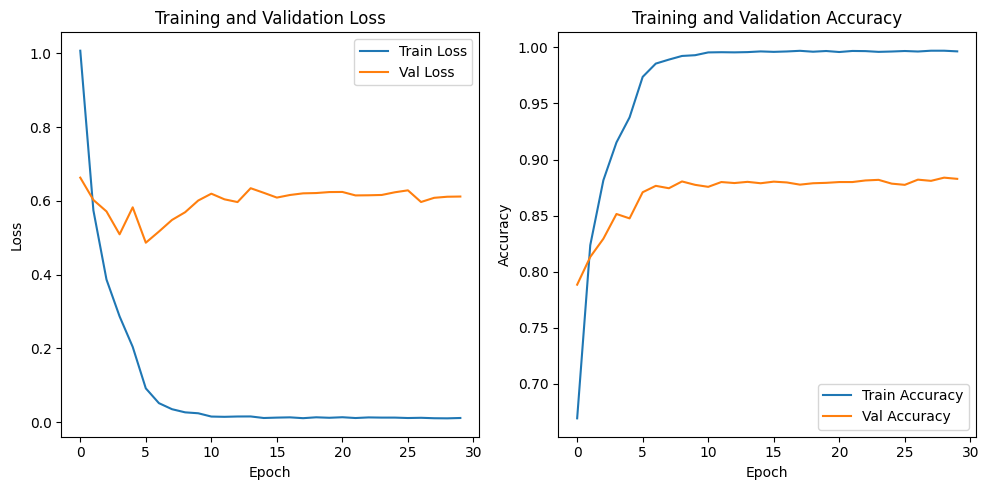

In [36]:
plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)